In [19]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from collections import Counter
from torchinfo import summary

def reverse_rna(seq='atgggcggcgcatgagagaagcccagaccaattacctacccaaa'):
    d = {"A":"U","C":"G","G":"C","T":"A"}
    return "".join([d[c.upper()] for c in seq])

def get_padding(kernel_size):
    left = (kernel_size - 1) // 2
    right= kernel_size - 1 - left
    return [ max(0,x) for x in [left,right] ]


class Tokenizer(object):

    def __init__(self,chars="acgu"):
        self.length = len(chars)
        self.chars = chars+"n"
        self.dchars = {c:[0]*self.length for c in self.chars}
        for i, c in enumerate(chars):
            self.dchars[c][i]=1

    def corpus(self,i):
        idx = i.argmax()
        return self.chars[idx]

    def decode(self, X,seq_len=None):
        mask = np.max(X,axis=-1)==0
        X = np.argmax(X,axis=-1)
        X = np.where(mask,-1,X)
        seqs = []
        for x in X:
            seq = "".join([self.chars[c] for c in x])
            seqs.append(seq)
        return seqs

    def encode(self,seqs,seq_len=None):
        vectors = np.empty([len(seqs),seq_len,self.length])
        for i,seq in enumerate(seqs):
            seq = seq[:seq_len].lower()
            lst = [self.dchars[x] for x in seq]
            if seq_len>len(seq):
                lst += [self.dchars['n']]*(seq_len-len(seq))
            a = np.array(lst)
            vectors[i] = a
        return vectors


def random_mutant(original_seq):
    # bg_seqs
    seqs = [original_seq]
    cnter = Counter()
    for i in range(len(original_seq)):
        for j, nt in enumerate(["A", "C", "G", "U"]):
            if seqs[i].upper()!=nt:
                seq = original_seq[:i] + nt + original_seq[i + 1 :]
                seqs.append(seq)
                cnter.update(seq.lower())
    total = sum(cnter.values())
    bgnts = {k:v/total for k,v in cnter.items()}
    entropy = sum(-v*np.log2(v) for v in bgnts.values())
    return seqs,bgnts,entropy

def random_seqs():
    name,seq_len,suff = "pl3-1-2",118,"" # _seq
    datadir=f"/data/home/jinyalong/data/sev_240624/results/{name}/{name}_"
    sdf = pd.read_csv(f"{datadir}final{suff}.csv")
    sdf["seq"] = sdf.seq.apply(reverse_rna)
    sdf = sdf[sdf.seq.str.len()==118]
    cnter = Counter()
    for s in sdf.seq.values:
        cnter.update(s.lower())
    total = sum(cnter.values())
    bgnts = {k:v/total for k,v in cnter.items()}
    entropy = sum(-v*np.log2(v) for v in bgnts.values())
    return sdf.seq.values,bgnts,entropy

class CNN(nn.Module):
    def __init__(self, kernel_size=5, seq_len=44):
        super(CNN, self).__init__()
        self.seq_len=seq_len
        self.kernel_size=kernel_size
        self.padding = get_padding(kernel_size)
        self.conv0 = nn.Conv1d(in_channels=4, out_channels=100, kernel_size=(5,), padding=2)
        self.conv1 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(5,), padding=2)
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=200, kernel_size=(5,), padding=2)
        self.conv3 = nn.Conv1d(in_channels=200, out_channels=200, kernel_size=(5,), padding=2)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool1d(2, stride=2)
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(200)
        self.linear = nn.Linear(200*(self.seq_len//4),100)
        self.output = nn.Linear(100,1)

    def forward(self, x,dummpy=None):
        bs = x.shape[0]
        x= torch.permute(x,(0,2,1))
        x = self.act(self.conv0(x))
        if dummpy:
            idx, value = dummpy
            x[:,idx,:]=value
        x = self.act(self.conv1(x))
        x = self.dropout(self.pool(x))
        x = self.act(self.conv2(x))
        x = self.pool(x)
        x = self.act(self.bn(self.conv3(x)))
        x = self.dropout(x).reshape((bs,-1))
        x = self.dropout(self.act(self.linear(x)))
        x = self.output(x)
        return x

refer_seq = "atcccgggtgaggcatcccaccatcctcagtcacagagagacccaatctaccatcagcatcagccagtaaagattaagaaaaacttagggtgaaagaaatttcacctaacacggcgca"
refer_seq = reverse_rna(refer_seq)
name,seq_len,suff = "pl3-1-2",118,"" # pl3-1-2, "core6-merge
seqs, bgnts, bgentropy= random_mutant(refer_seq)
# seqs, bgnts, bgentropy= random_seqs()
kernel_size=5
# seqs, bgnts,bgentropy = random_seqs()
print(bgnts,bgentropy)
tlp = "/data/home/jinyalong/git/txdas/biotech/notebook/SEV_Promoter"
fn = f"{tlp}/models/{name}-{kernel_size}.pt"
model = CNN(kernel_size=kernel_size, seq_len=seq_len)
model.load_state_dict(torch.load(fn,weights_only=True))
# model = torch.load(fn,weights_only=False)
summary(model, input_size=(16, seq_len, 4))
import inspect
inspect.signature(model.forward)

{'a': 0.1701738006320023, 'g': 0.279409652398736, 'c': 0.19538207411663316, 'u': 0.35503447285262857} 1.9394256388800057


<Signature (x, dummpy=None)>

In [20]:
from torchinfo import summary
from scipy import stats
import phate
device = "cuda:0"


class MotifSearch(object):

    def __init__(self,lib):
        self.pwms = np.load(lib)

    def similarity(self,motif1,motif2):
        corr = np.corrcoef(motif1, motif2)
        slen = motif1.shape[0]
        return np.diagonal(corr,offset=slen).mean()

    def most_similarity(self,motif):
        sim = -1
        for i in range(len(pwms)):
            score = self.similarity(pwms[i],motif)
            if score>sim:
                sim = score
        return sim


class Intepreter(object):
    def __init__(self, model_name,original_seq=None):
        self.original_seq = original_seq
        self.token = Tokenizer()
        self.model_name = model_name
        self.model = model.to(device)
        self.kernel_size = self.model.kernel_size
        self.padding = self.model.padding


    def extract_layer_output(self, X, layer_name):
        activation = {}

        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        getattr(self.model, layer_name).register_forward_hook(get_activation(layer_name))
        self.model.eval()
        X = torch.tensor(X).float().to(device)
        y = self.model(X).detach().cpu().numpy()
        layer_output = activation[layer_name].detach().cpu().numpy()
        return layer_output,y

    def extract_motifs_layer2(self,seqs,n_samples=200):
        onehot_seqs = self.token.encode(seqs,118)
        onehot_seqs_pad =  np.pad(onehot_seqs, ((0,0),(4,4),(0,0)), 'constant', constant_values=0)
        # conv_out [batch_size, filter, length]
        conv_out, pred = self.extract_layer_output(onehot_seqs,"conv0")
        filter_size, filter_width = conv_out.shape[1], self.kernel_size*2-1
        pwms = np.zeros((filter_size, filter_width, 4))
        pwms_top = np.zeros((filter_size, filter_width, 4))
        pr = np.zeros(filter_size)
        conv_out_max = np.max(conv_out,axis=-1)
        for k in range(filter_size) :
            pr[k] = stats.pearsonr(conv_out_max[:,k].reshape((-1,1)),pred)[0] if np.unique(conv_out_max[:,k]).shape[0]>1 else 0
            for i in range(conv_out.shape[0]) :
                max_j = np.argmax(conv_out[i, k, :])
                if conv_out[i, k, max_j] > 0 :
                    pwms[k, :, :] += onehot_seqs_pad[i, max_j: max_j+filter_width, :]
            sort_index = np.argsort(np.max(conv_out[:, k, :], axis=-1))[::-1]
            for i in range(n_samples) :
                max_j = np.argmax(conv_out[sort_index[i], k, :])
                if conv_out[sort_index[i], k, max_j] > 0 :
                    pwms_top[k, :, :] += onehot_seqs_pad[sort_index[i], max_j: max_j+filter_width, :]
            pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1)+1e-10, axis=-1)
            pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1)+1e-10, axis=-1)

        return pwms,pwms_top


    def extract_motifs(self,seqs,n_samples=200):
        # onehot_seqs [size, length, 4]
        onehot_seqs = self.token.encode(seqs,118)
        onehot_seqs_pad =  np.pad(onehot_seqs, ((0,0),self.padding,(0,0)), 'constant', constant_values=0)
        # conv_out [batch_size, filter, length]
        conv_out, pred = self.extract_layer_output(onehot_seqs,"conv0")
        filter_size, filter_width = conv_out.shape[1], self.kernel_size
        pwms = np.zeros((filter_size, filter_width, 4))
        pwms_top = np.zeros((filter_size, filter_width, 4))
        pr = np.zeros(filter_size)
        conv_out_max = np.max(conv_out,axis=-1)
        for k in range(filter_size) :
            pr[k] = stats.pearsonr(conv_out_max[:,k].reshape((-1,1)),pred)[0] if np.unique(conv_out_max[:,k]).shape[0]>1 else 0
            for i in range(conv_out.shape[0]) :
                max_j = np.argmax(conv_out[i, k, :])
                if conv_out[i, k, max_j] > 0 :
                    pwms[k, :, :] += onehot_seqs_pad[i, max_j: max_j+filter_width, :]
            sort_index = np.argsort(np.max(conv_out[:, k, :], axis=-1))[::-1]
            for i in range(n_samples) :
                max_j = np.argmax(conv_out[sort_index[i], k, :])
                if conv_out[sort_index[i], k, max_j] > 0 :
                    pwms_top[k, :, :] += onehot_seqs_pad[sort_index[i], max_j: max_j+filter_width, :]
            pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1)+1e-10, axis=-1)
            pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1)+1e-10, axis=-1)
        df = pd.DataFrame(data={"pr":pr,"idx":range(filter_size)})
        phate_op = phate.PHATE()
        phates =  phate_op.fit_transform(pwms_top.reshape((filter_size,-1)))
        df["PHATE 1"] =phates[:,0]
        df["PHATE 2"] =phates[:,1]
        return pwms,pwms_top,df

    def extract_kernel(self,idx,layer_name="conv0"):
        conv_layer = getattr(self.model, layer_name)
        kernels = conv_layer.weight.detach().cpu().numpy()
        kernel = kernels[idx,...]
        scores = (kernel - kernel.min(axis=0))/(kernel.max(axis=0) - kernel.min(axis=0))
        return scores.T

    def saliency(self, original_seq=None):
        if original_seq is None:
            original_seq = self.original_seq
        original_score = self.predict_score(original_seq)[0]
        seqs = []
        for i in range(len(original_seq)):
            for j, nt in enumerate(["A", "C", "G", "U"]):
                seq = original_seq[:i] + nt + original_seq[i + 1 :]
                seqs.append(seq)
        scores = self.predict_score(seqs)
        saliency_arr = scores.reshape((4, len(original_seq)))
        saliency_arr -= original_score
        return saliency_arr

    def predict_score(self, seqs):
        X = torch.tensor(self.token.encode(seqs,118)).float().to(device)
        score = self.model.forward(X)
        score = score.detach().cpu().numpy()
        return score

    def extract_phate(self,seqs):

        return data_phate

    def kernal_importance(self,seqs):
        onehot_seqs = self.token.encode(seqs,118)
        conv_out, basescore = self.extract_layer_output(onehot_seqs,"conv0")
        filter_size = conv_out.shape[1]
        means = conv_out.mean(axis=(0,2))
        X = torch.tensor(onehot_seqs).float().to(device)
        deltas = []
        for i in range(filter_size):
            scores = self.model.forward(X,dummpy=(i,float(means[i]))).detach().cpu().numpy()
            delta = np.absolute(scores-basescore).mean()
            deltas.append(delta)
        importances=np.array(deltas)
        imp_min, imp_max = importances.min(), importances.max()
        importances = (importances-imp_min)/(imp_max-imp_min)
        midxs  = []
        for i in range(len(importances)):
            loss_ref=self.extract_kernel(i)
            max_score,match_idx = -10, -1
            for j in range(self.kernel_size,len(self.original_seq)):
                tmps = [refer_seq[j-self.kernel_size :j]]
                tx = intepreter.token.encode(tmps,seq_len=self.kernel_size )[0]
                score = loss_ref[range(self.kernel_size ),np.argmax(tx, axis=1)].sum()
                if score > max_score : # and 72<j<97
                    max_score = score
                    match_idx = j
            midxs.append(match_idx)
        return pd.DataFrame(data={"center":midxs,"importance":importances,"idx":range(filter_size)})

    def summary(self,seq_len=None):
        return summary(self.model, input_size=(16, self.token.seq_len, 4))


intepreter = Intepreter(name,original_seq=refer_seq)
pwms,pwms_top,rdf= intepreter.extract_motifs(seqs)
pwms2,pwms_top2= intepreter.extract_motifs_layer2(seqs)
# # print(intepreter.extract_kernel(0,).shape)
importances = intepreter.kernal_importance(seqs)
importances = importances.merge(rdf)
np.save(f"{name}_pwns.npy",pwms_top)
# # print(intepreter.saliency())
# # intepreter.summary()
# cname = "pl5-1-2"
# ms = MotifSearch(f"{cname}_pwns.npy")
# importances["similarity"] = [ms.most_similarity(v) for v in pwms_top]
importances.sort_values(by="importance",ascending=False)[:10]


/tmp/ipykernel_1863096/2977728015.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pr[k] = stats.pearsonr(conv_out_max[:,k].reshape((-1,1)),pred)[0] if np.unique(conv_out_max[:,k]).shape[0]>1 else 0


Calculating PHATE...
  Running PHATE on 100 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 45
  Calculated optimal t in 0.38 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...
Calculated PHATE in 0.48 seconds.


/tmp/ipykernel_1863096/2977728015.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pr[k] = stats.pearsonr(conv_out_max[:,k].reshape((-1,1)),pred)[0] if np.unique(conv_out_max[:,k]).shape[0]>1 else 0


,center,importance,idx,pr,PHATE 1,PHATE 2
15,56,1.000000,15,0.037608,0.092562,0.032832
98,72,0.906070,98,-0.034314,-0.028463,0.023621
1,73,0.887211,1,-0.076244,0.014377,0.005798
85,17,0.811306,85,0.016796,-0.084797,-0.027347
8,9,0.751225,8,0.018239,0.154587,-0.114569
48,90,0.744237,48,-0.180699,-0.053918,-0.020396
37,71,0.691316,37,-0.047428,-0.019404,0.007722
25,104,0.645077,25,-0.041358,0.044537,0.043993
89,45,0.628340,89,-0.090494,-0.038324,-0.003276
10,46,0.611642,10,-0.073775,-0.048950,-0.006069


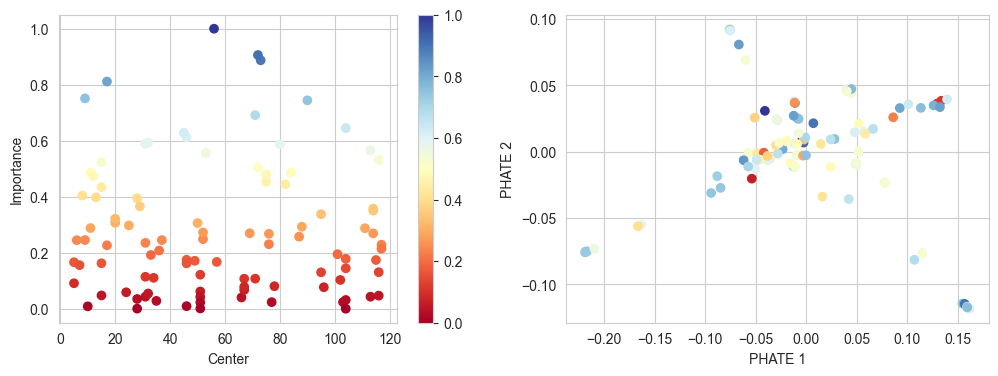

In [21]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1,2,figsize=(12,4))
sdf = importances
cm = plt.get_cmap('RdYlBu')
plt.subplot(1, 2, 1)
sc = plt.scatter(sdf["center"], sdf["importance"], c=sdf["importance"], cmap=cm)
plt.colorbar(sc)
plt.xlabel("Center")
plt.ylabel("Importance")
plt.subplot(1, 2, 2)
sc = plt.scatter(sdf["PHATE 1"], sdf["PHATE 2"], c=sdf["pr"], cmap=cm)
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")
plt.show()

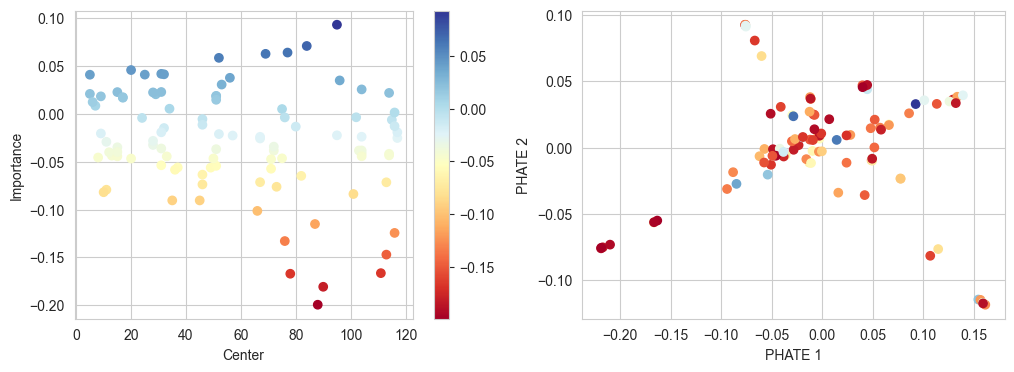

In [22]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1,2,figsize=(12,4))
sdf = importances
cm = plt.get_cmap('RdYlBu')
plt.subplot(1, 2, 1)
sc = plt.scatter(sdf["center"], sdf["pr"], c=sdf["pr"], cmap=cm)
plt.colorbar(sc)
plt.xlabel("Center")
plt.ylabel("Importance")
plt.subplot(1, 2, 2)
sc = plt.scatter(sdf["PHATE 1"], sdf["PHATE 2"], c=sdf["importance"], cmap=cm)
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")
plt.show()


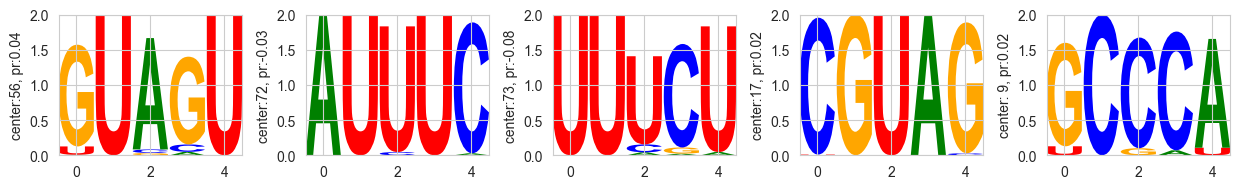

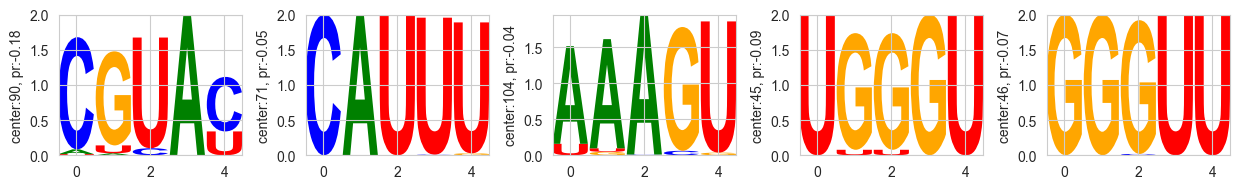

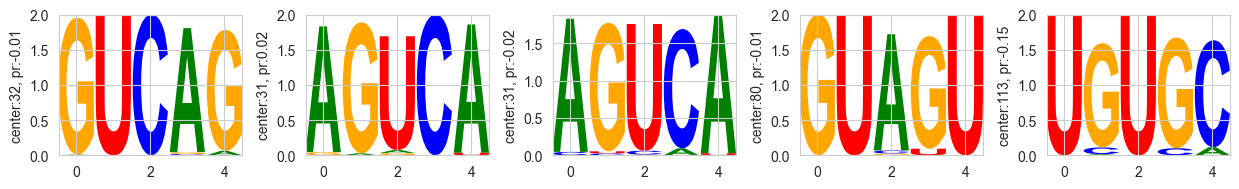

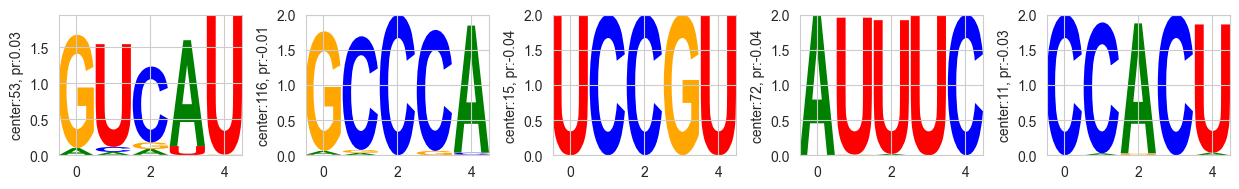

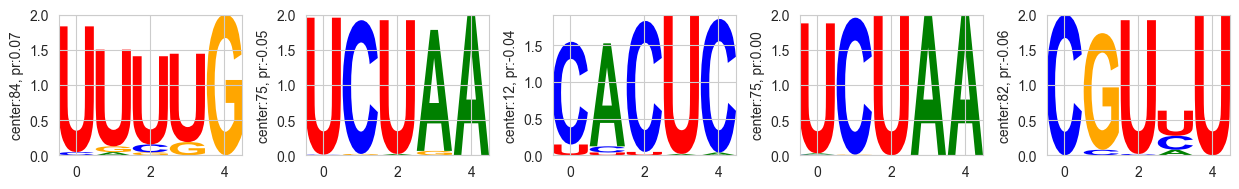

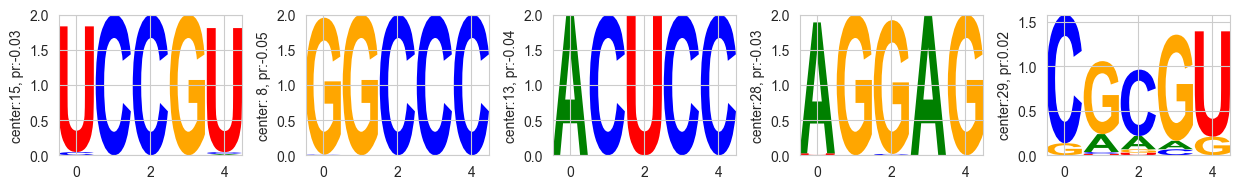

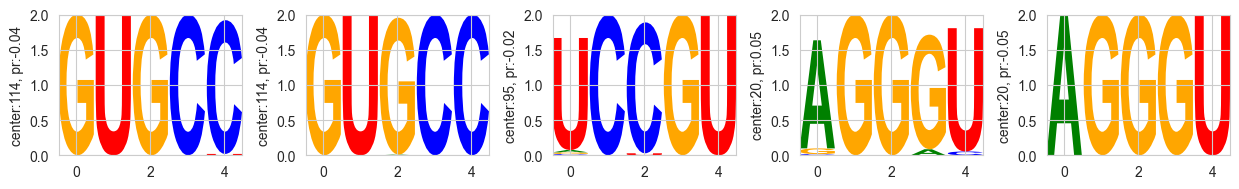

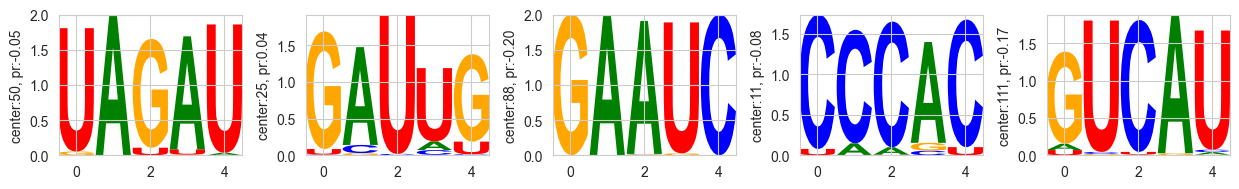

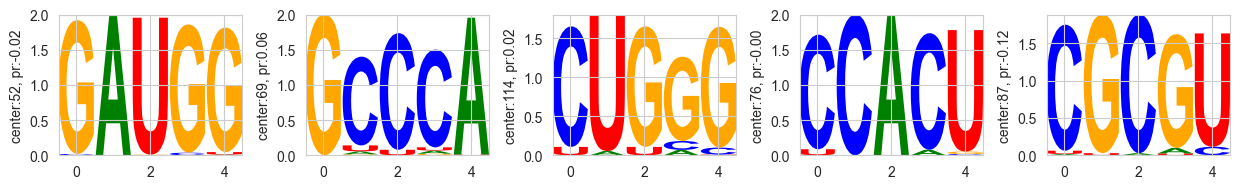

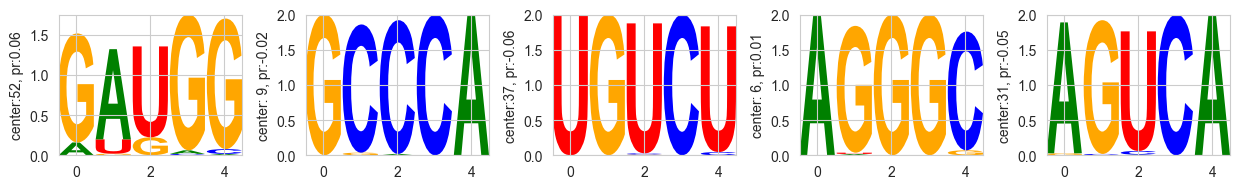

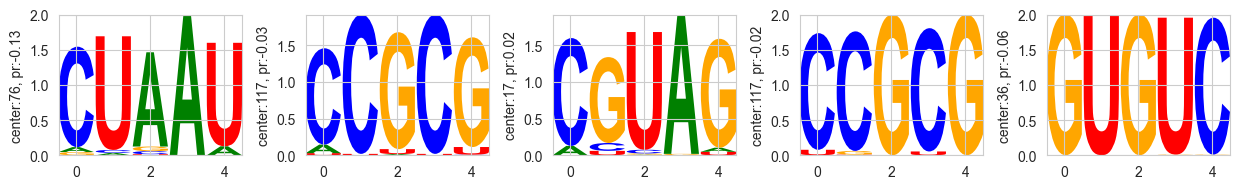

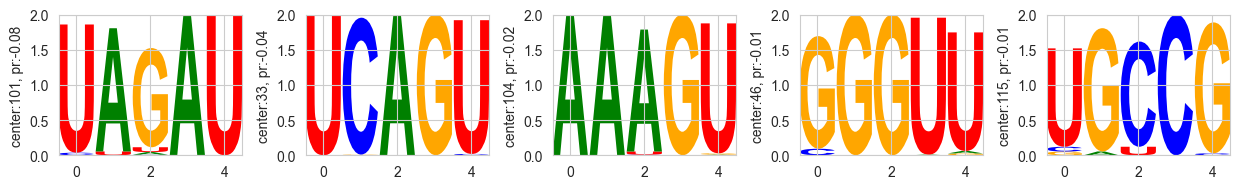

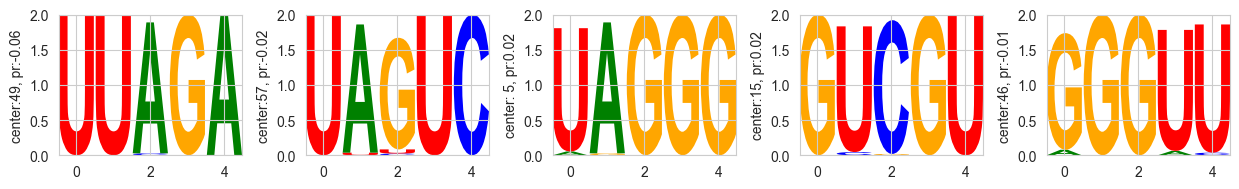

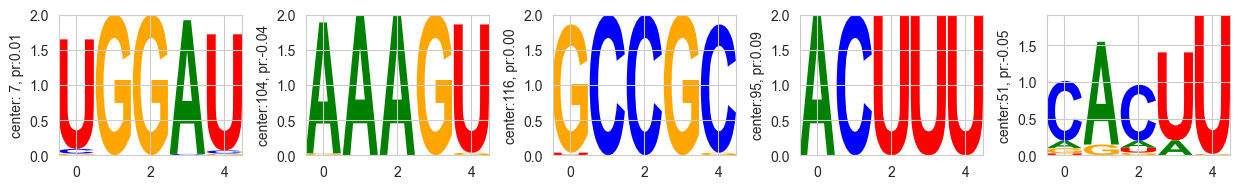

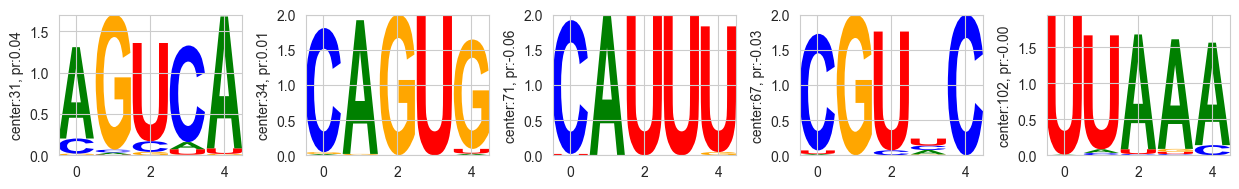

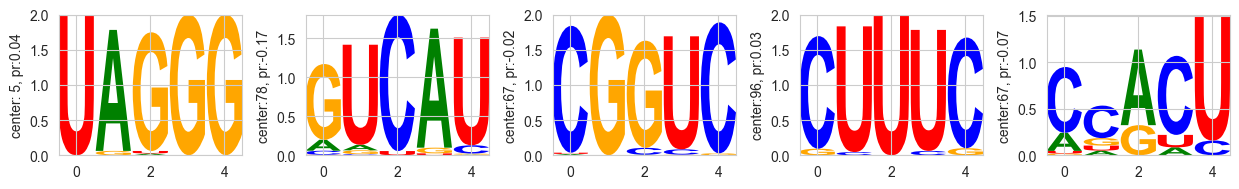

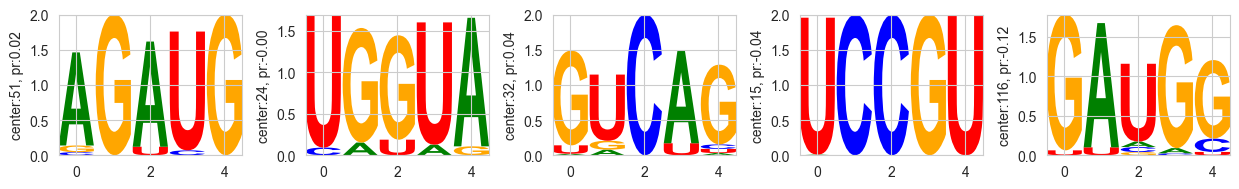

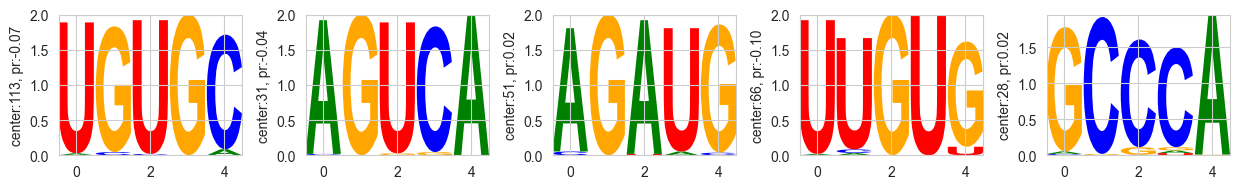

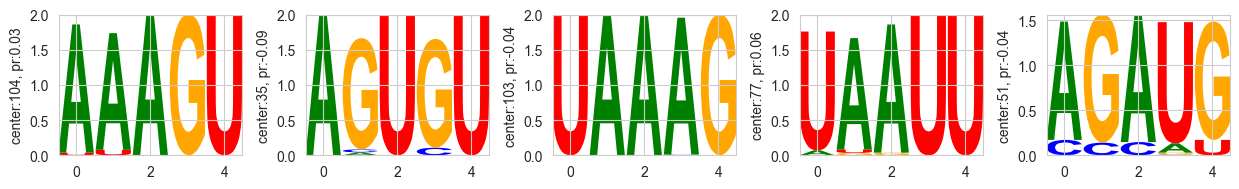

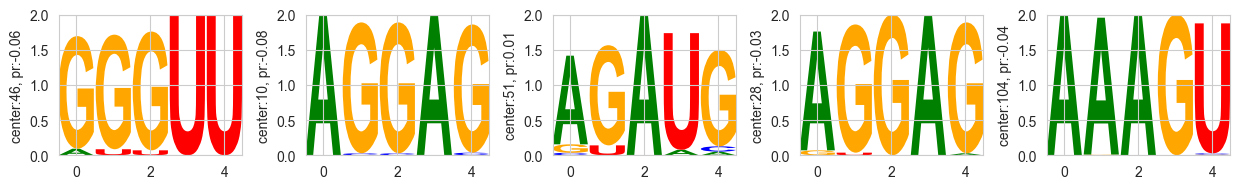

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker

def to_motif(ppm):
    entropy = np.zeros(ppm.shape)
    entropy[ppm > 0] = ppm[ppm > 0] * -np.log2(ppm[ppm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy
    probs = np.multiply(ppm, conservation.reshape((-1, 1)))
    return pd.DataFrame(probs,columns=['A','C','G','U'])

n_filters_per_row = 5
n_rows = int(pwms.shape[0] / n_filters_per_row)
sidxs = importances.sort_values(by="importance",ascending=False).idx.values
for row_i in range(n_rows) :
    f, axs = plt.subplots(1,n_filters_per_row, figsize=(2.5 * n_filters_per_row, 2))
    for kk in range(n_filters_per_row) :
        # pwm [ kernel, 4]
        sidx = sidxs[kk+row_i*n_filters_per_row]
        pwm=pwms_top[sidx]
        seq_df = to_motif(pwm)
        logo =logomaker.Logo(seq_df,ax=axs[kk])
        imp = importances.iloc[sidx]
        logo.ax.set_ylabel(f'center:{imp.center:2.0f}, pr:{imp.pr:.2f}')
    plt.sca(plt.gca())
    plt.tight_layout()
    plt.show()

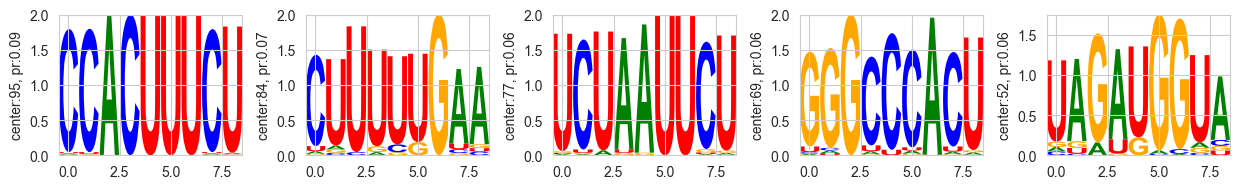

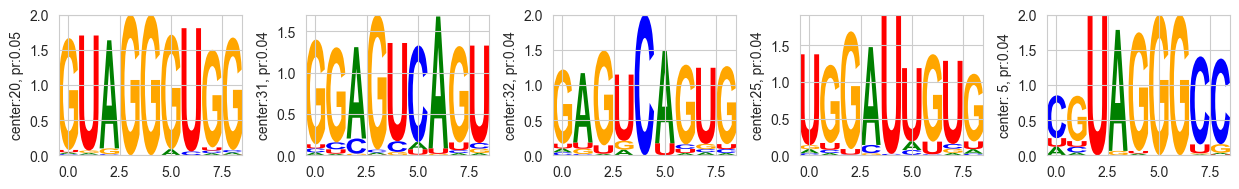

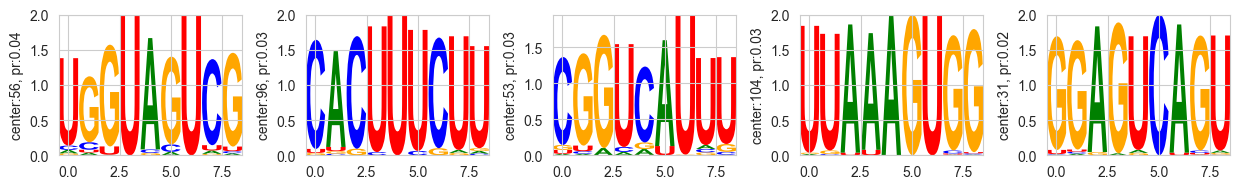

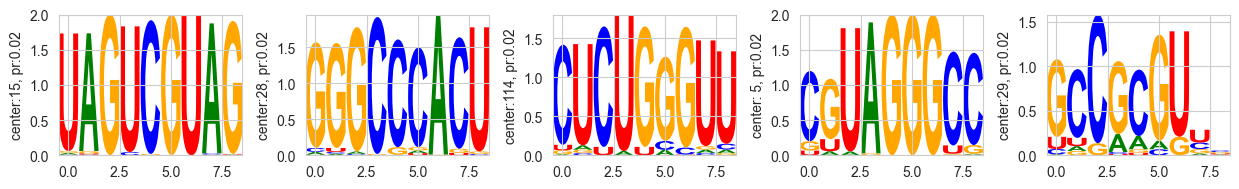

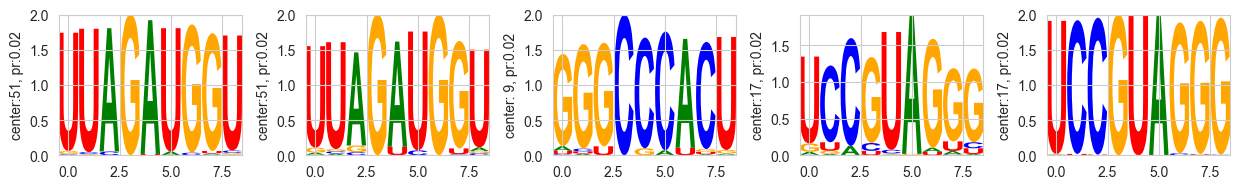

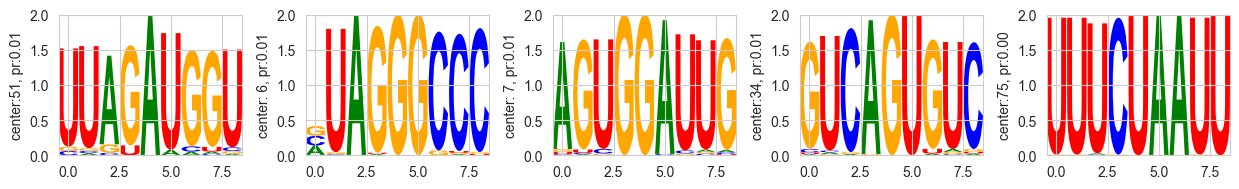

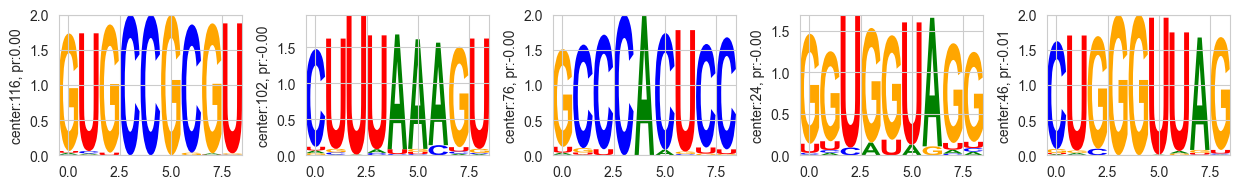

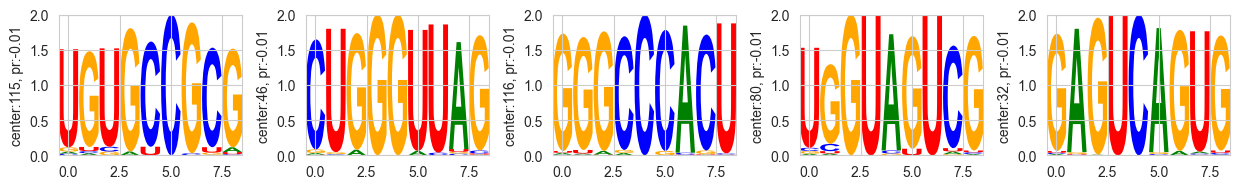

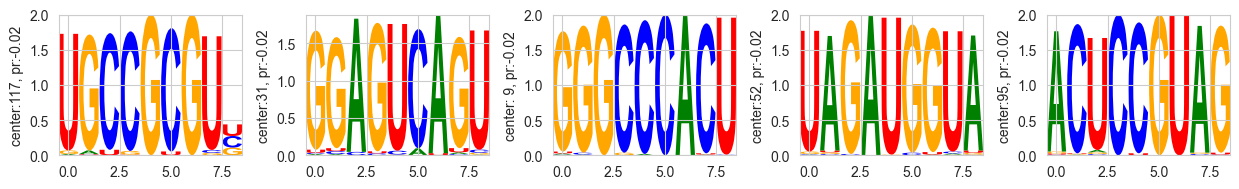

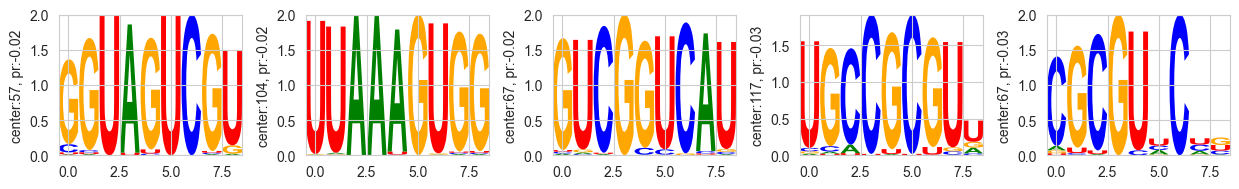

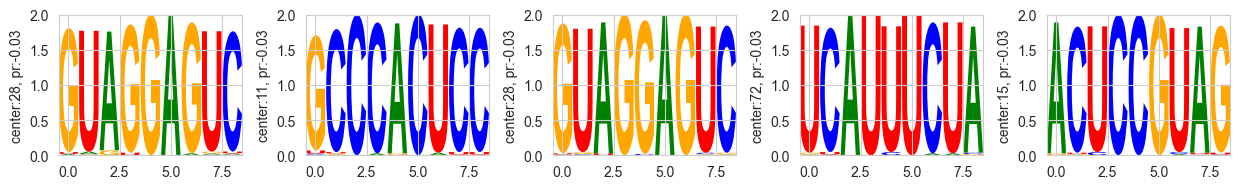

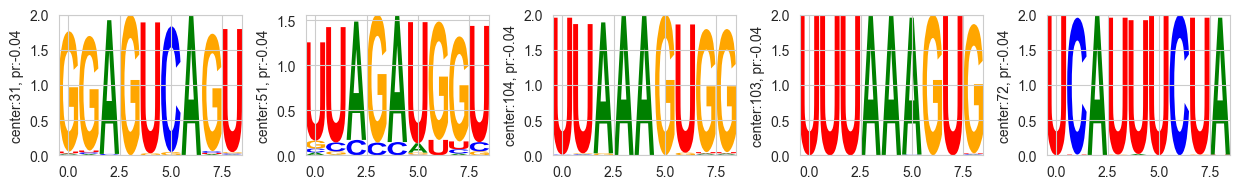

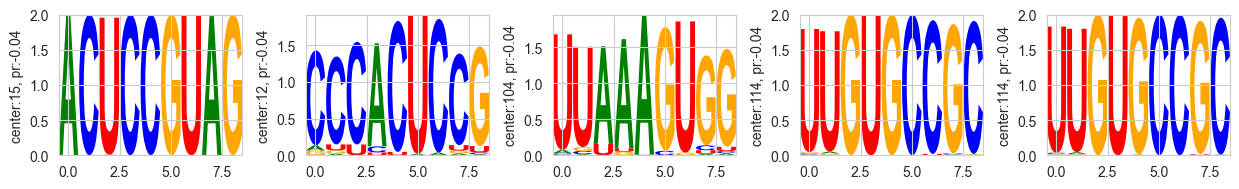

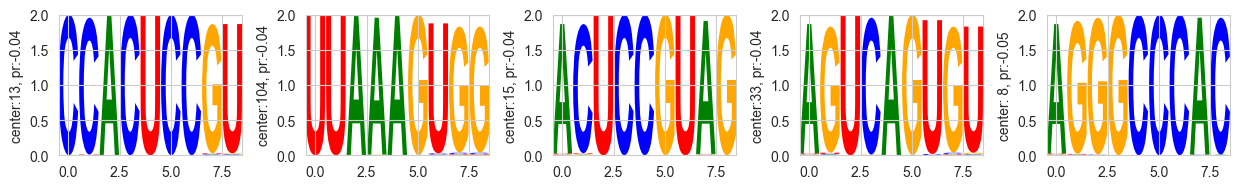

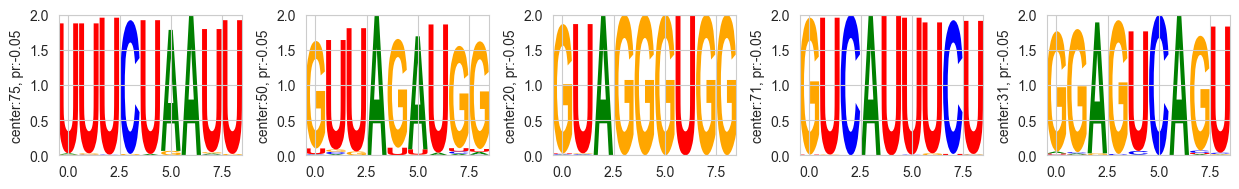

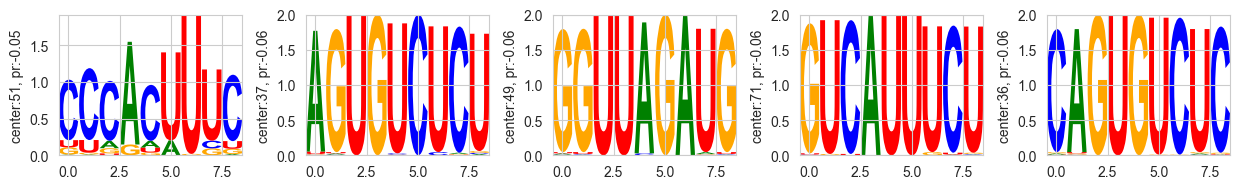

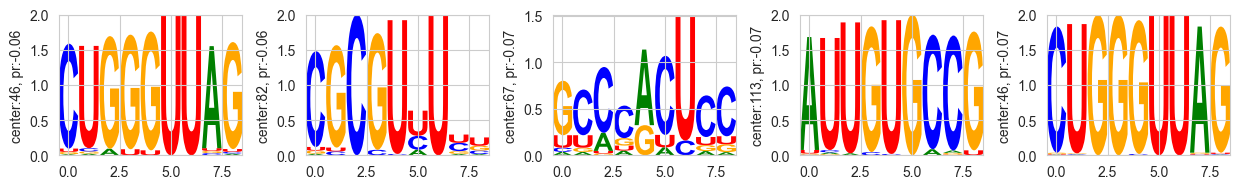

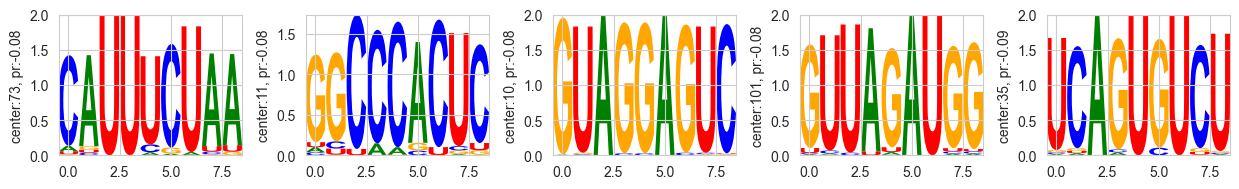

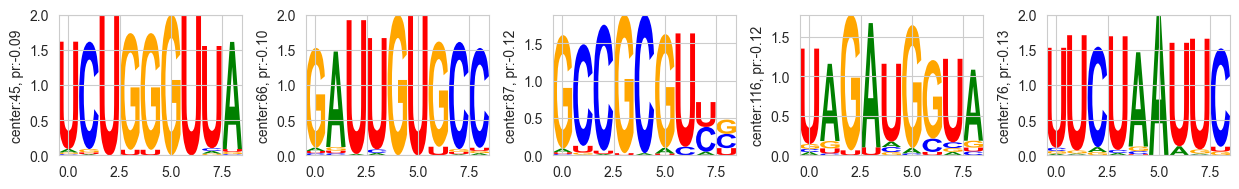

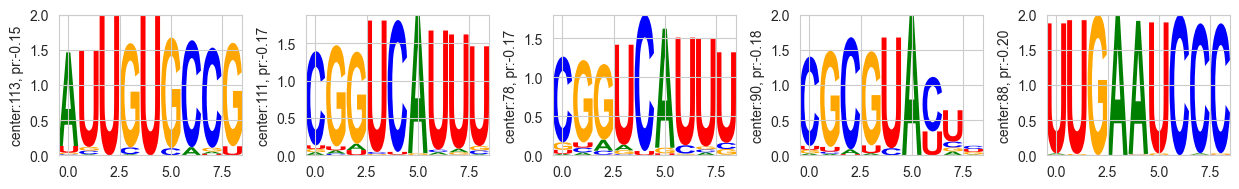

In [25]:
n_filters_per_row = 5
n_rows = int(pwms.shape[0] / n_filters_per_row)
sidxs = importances.sort_values(by="pr",ascending=False).idx.values
for row_i in range(n_rows) :
    f, axs = plt.subplots(1,n_filters_per_row, figsize=(2.5 * n_filters_per_row, 2))
    for kk in range(n_filters_per_row) :
        # pwm [ kernel, 4]
        sidx = sidxs[kk+row_i*n_filters_per_row]
        pwm=pwms_top2[sidx]
        seq_df = to_motif(pwm)
        logo =logomaker.Logo(seq_df,ax=axs[kk])
        imp = importances.iloc[sidx]
        logo.ax.set_ylabel(f'center:{imp.center:2.0f}, pr:{imp.pr:.2f}')
    plt.sca(plt.gca())
    plt.tight_layout()
    plt.show()